In [553]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from skimage.filters import threshold_local
from craft_hw_ocr import OCR

In [554]:

class ShapeDetector:
	def __init__(self):
		self.ocr_models = OCR.load_models()
		pass

	def predict_shape(self, c):
		
		shape = "unidentified"
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.04 * peri, True)
		# if the shape is a triangle, it will have 3 vertices
		if len(approx) == 3:
			shape = "triangle"
		# if the shape has 4 vertices, it is either a square or
		# a rectangle
		elif len(approx) == 4:
			# compute the bounding box of the contour and use the
			# bounding box to compute the aspect ratio
			(x, y, w, h) = cv2.boundingRect(approx)
			ar = w / float(h)
			# a square will have an aspect ratio that is approximately
			# equal to one, otherwise, the shape is a rectangle
			shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
		# if the shape is a pentagon, it will have 5 vertices
		elif len(approx) == 5:
			shape = "pentagon"
		# otherwise, we assume the shape is a circle
		else:
			shape = "circle"
	
		return shape
	
	def OCR(self, image):

		img_ocr, results = OCR.detection(image, self.ocr_models[2])

		img_text_cleared = img_ocr.copy()

		bboxes, texts = OCR.recoginition(img_ocr, results, self.ocr_models[0], self.ocr_models[1])

		return bboxes, img_text_cleared, texts

	def detect_shapes(self, image, ocr=True):

		# do the below step if your image is tilted by some angle else ignore
		# img = OCR.process_image(img)

		
		bboxes, img_text_cleared, texts = self.OCR(image)

		image_copy = image.copy()
		
		T = threshold_local(img_text_cleared, 27, offset = 17, method = "gaussian")
		img_text_cleared = (img_text_cleared > T).astype("uint8") * 255
	
		T = threshold_local(image_copy, 27, offset = 17, method = "gaussian")
		image_copy = (image_copy > T).astype("uint8") * 255
		
		for i in bboxes.astype('int32'):
			cv2.fillPoly(img_text_cleared, pts=[i], color=(255,255,255))
			
		resized = imutils.resize(img_text_cleared, width=100)
		ratio = img_text_cleared.shape[0] / float(resized.shape[0])
		gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
		# blurred = cv2.GaussianBlur(gray, (7, 7), 0)

		# thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]

		thresh = cv2.bitwise_not(gray)
		
		cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)

		# def reject_outliers(data, m=1):
		# 	filtered_contours= []
		# 	contour_areas = [cv2.contourArea(i) for i in data]
		# 	for i in data:
		# 		contour_area = cv2.contourArea(i)
		# 		if abs(contour_area - np.mean(contour_areas)) > m * np.std(contour_areas):
		# 			filtered_contours.append(i)
		# 	return filtered_contours
				
		# filtered_contours = reject_outliers(cnts)

		for c in cnts:

			if cv2.contourArea(c) < 4:
				continue
			
			M = cv2.moments(c)
			if M["m00"] > 0:
				cX = int((M["m10"] / M["m00"]) * ratio)
				cY = int((M["m01"] / M["m00"]) * ratio)
				shape = self.predict_shape(c)
				c = c.astype("float")
				c *= ratio
				c = c.astype("int")

				cv2.drawContours(image_copy, [c], -1, (255, 0, 0), 2)
				cv2.putText(image_copy, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,
					0.5, (0, 0, 255), 2)
				
		for i,j in enumerate(bboxes):

			y1 = int(bboxes[i][0][1])
			y2 = int(bboxes[i][2][1])
			
			x1 = int(bboxes[i][0][0])
			x2 = int(bboxes[i][2][0])
			
			cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0,0,255), 2)
		

		return image_copy, texts
			


In [555]:

class Preprocessing:

    def __init__(self) -> None:
        pass

    def shadow_remove(self, img):
            rgb_planes = cv2.split(img)
            result_norm_planes = []
            for plane in rgb_planes:
                dilated_img = cv2.dilate(plane, np.ones((17,17), np.uint8))
                bg_img = cv2.medianBlur(dilated_img, 21)
                diff_img = 255 - cv2.absdiff(plane, bg_img)
                norm_img = cv2.normalize(diff_img,None, alpha=40, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
                result_norm_planes.append(norm_img)
            shadowremov = cv2.merge(result_norm_planes)
            return shadowremov

    def order_points(self,pts):
        # initialzie a list of coordinates that will be ordered
        # such that the first entry in the list is the top-left,
        # the second entry is the top-right, the third is the
        # bottom-right, and the fourth is the bottom-left
        rect = np.zeros((4, 2), dtype = "float32")
        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = pts.sum(axis = 1) 
        rect[0] = pts[np.argmin(s)] 
        rect[2] = pts[np.argmax(s)] 
        # now, compute the difference between the points, the
        # top-right point will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)] 
        rect[3] = pts[np.argmax(diff)] 
        # return the ordered coordinates
        return rect
    
    def four_point_transform(self,image, pts):

        # obtain a consistent order of the points and unpack them
        # individually
        rect = self.order_points(pts)
        (tl, tr, br, bl) = rect 
        # compute the width of the new image, which will be the
        # maximum distance between bottom-right and bottom-left
        # x-coordiates or the top-right and top-left x-coordinates
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2)) 
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        # compute the height of the new image, which will be the
        # maximum distance between the top-right and bottom-right
        # y-coordinates or the top-left and bottom-left y-coordinates
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        # now that we have the dimensions of the new image, construct
        # the set of destination points to obtain a "birds eye view",
        # (i.e. top-down view) of the image, again specifying points
        # in the top-left, top-right, bottom-right, and bottom-left
        # order
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")
        # compute the perspective transform matrix and then apply it
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
        # return the warped image
        return warped
    
    def scan_image(self, image):
           
        ratio = image.shape[0] / 700.0
        orig = image.copy()
        image = imutils.resize(image, height = 700)
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        edged = cv2.Canny(gray, 100, 255)

        
        cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
        
        print([cv2.contourArea(i) for i in cnts])

        for c in cnts:
            # approximate the contour
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            # if our approximated contour has four points, then we
            # can assume that we have found our screen
            print(len(approx))
            
            if len(approx) == 4:
                screenCnt = approx
                break
        # show the contour (outline) of the piece of paper
        cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)

        

        warped = self.four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
        warped = warped[20:-20,20:-20]

        return warped

In [556]:
preprocessing = Preprocessing()
shape_detector = ShapeDetector()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[277205.0, 277193.0, 269416.0, 269412.0, 106.5]
4
line 0 has been recoginized
line 1 has been recoginized
line 2 has been recoginized
line 3 has been recoginized
line 4 has been recoginized
line 5 has been recoginized
line 6 has been recoginized
line 7 has been recoginized
line 8 has been recoginized
line 9 has been recoginized
line 10 has been recoginized
line 11 has been recoginized
line 12 has been recoginized
line 13 has been recoginized


True

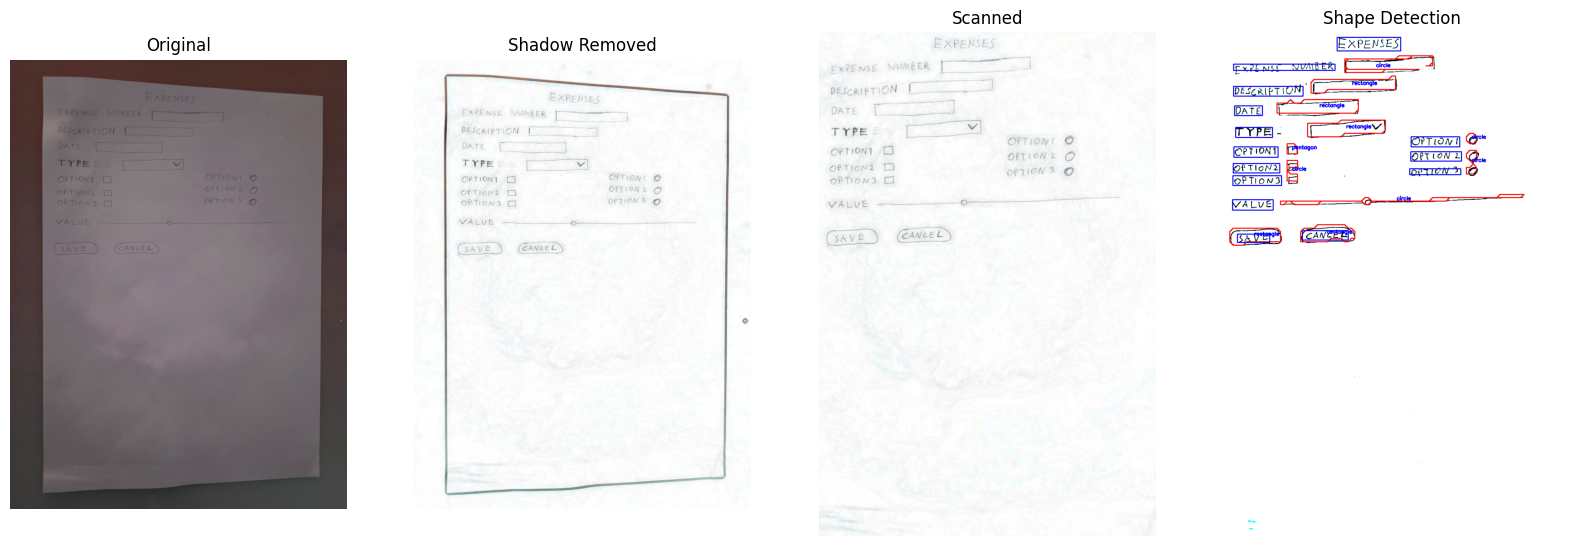

In [557]:
filename = "2.jpg"
image = cv2.imread(filename)


img_shadow_removed = preprocessing.shadow_remove(image)
img_scanned = preprocessing.scan_image(img_shadow_removed)
img_shape_detected, texts = shape_detector.detect_shapes(img_scanned.copy(), ocr=True)

fig = plt.figure(figsize=(20, 30))

figures = { "Original": image,
			"Shadow Removed": img_shadow_removed,
			"Scanned": img_scanned,
			"Shape Detection": img_shape_detected
			}

for i,key in enumerate(figures):

	fig.add_subplot(2, 4, i+1)
	plt.imshow(figures[key])
	plt.axis('off')
	plt.title(key)

cv2.imwrite(filename.split('.')[0]+"_detected.jpg",img_shape_detected)


In [558]:
texts.split('\n')

['expenses',
 'expensive number',
 'description',
 'date',
 'type',
 'copticant',
 'option!',
 'optional',
 'option?',
 '#',
 'option 3',
 'value',
 'rancel',
 'save']